In [1]:
import os
from torch_geometric.datasets import TUDataset
import os.path as osp
from torch_geometric.loader import DenseDataLoader
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool,dense_mincut_pool
import torch_geometric.transforms as T
from sklearn.model_selection import KFold

import sys
sys.path.append("/home/rohit/PhD_Work/GM_my_version/Graph_matching/")
from sklearn.cluster import KMeans
import networkx as nx
import numpy as np
from graph_generation.load_graphs_and_create_metadata import dataset_metadata
from graph_matching_tools.metrics import matching
import matplotlib.pyplot as plt
import scipy.io as sco
import slam.io as sio
from scipy.special import softmax
import pickle
from scipy.stats import betabinom
import seaborn as sns
import tools.graph_processing as gp
import tools.graph_visu as gv
from matplotlib.pyplot import figure
import pandas as pd
import random
from torch_geometric.utils.convert import from_networkx
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn.functional import one_hot
from sklearn.preprocessing import OneHotEncoder
from torch.nn import Linear
import torch.nn.functional as F
from math import ceil
import torch_geometric as pyg
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import TopKPooling
from torch_geometric.data import Data
from torch_geometric.loader import DenseDataLoader
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.nn import GCNConv, DenseGraphConv
%matplotlib inline

In [2]:
path_to_labelled_graphs = '/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/Oasis_original_new_with_dummy/modified_graphs/'

correspondence = pickle.load( open( "graph_correspondence_new.pickle", "rb" ) )

Oasis_phen = pd.read_excel("/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/OASIS_phenotype.ods", engine="odf")

In [3]:
# Correspondence between sulcal graphs(OASIS) and gender. 

#Oasis_phen[['Subject','M/F']]
oasis_ids = Oasis_phen['Subject'].to_list()
gender = Oasis_phen['M/F'].to_list()

gender_corresp = []

for corr in correspondence:
    corr_id = corr[0].split('_lh')
    
    for o_id, gen in zip(oasis_ids, gender):
        if o_id == corr_id[0]:
            gender_corresp.append([o_id,corr[1],gen])

In [4]:
def graph_remove_dummy_nodes(graph):
    nodes_dummy_true = [x for x,y in graph.nodes(data=True) if y['is_dummy']==True]
    graph.remove_nodes_from(nodes_dummy_true)
    #print(len(graph.nodes))

In [5]:
# Create graph level labels (here gender)
onehot = OneHotEncoder(drop='first')
graph_labels = onehot.fit_transform(np.array(gender_corresp)[:,2].reshape(-1,1)).toarray()

In [6]:
# Convert networkx graphs to pyg graphs

list_graphs = gp.load_graphs_in_list(path_to_labelled_graphs)

sulcal_dataset = []

for i,g in enumerate(list_graphs):
    graph_remove_dummy_nodes(g) # remove dummy nodes
    g.remove_edges_from(nx.selfloop_edges(g)) # remove self loop edges
    
    attr_coords = np.array(list(nx.get_node_attributes(g,'sphere_3dcoords').values()))
    attr_basin_area = np.array(list(nx.get_node_attributes(g,'basin_area').values())).reshape([len(g),1])
    attr_basin_thickness = np.array(list(nx.get_node_attributes(g,'basin_thickness').values())).reshape([len(g),1])
    attr_depth = np.array(list(nx.get_node_attributes(g,'depth').values())).reshape([len(g),1])
    
    attr_concat = np.concatenate((attr_coords,attr_basin_area,attr_basin_thickness,attr_depth),axis = 1)
    
    #attr_concat = attr_coords
    
    x = torch.tensor(attr_concat,dtype=torch.float)
    
    #x = torch.tensor(nx.adjacency_matrix(g).todense(),dtype=torch.float)
    y = torch.tensor(graph_labels[i],dtype=torch.long)
    edge_index = torch.tensor(list(g.edges))
    
    sulcal_dataset.append(Data(x=x, y=y, edge_index=edge_index.t().contiguous()))
    
    #sulcal_dataset.append(from_networkx(g))

In [7]:
k = 8
splits=KFold(n_splits=k,shuffle=True,random_state=42)

In [8]:
num_node_features = sulcal_dataset[0].num_features
num_node_features

6

In [9]:
class topk(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, embed_dim=32):
        super(topk, self).__init__()
        
        
        self.conv1 = GraphConv(num_node_features, embed_dim)
        self.pool1 = TopKPooling(embed_dim, ratio=0.6)
        self.conv2 = GraphConv(embed_dim, embed_dim)
        self.pool2 = TopKPooling(embed_dim, ratio=0.6)

        self.lin1 = torch.nn.Linear(embed_dim * 2, out_channels)
        #self.lin2 = torch.nn.Linear(embed_dim, out_channels)


    def forward(self, x, edge_index, batch):
        

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index_1, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index_1))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index_1, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)


        g_emb = x1 + x2

        x = F.relu(g_emb)
        out = self.lin1(x)
        
        return out, g_emb, edge_index_1
        

model = topk(num_node_features, 2)
print(model)

topk(
  (conv1): GraphConv(6, 32)
  (pool1): TopKPooling(32, ratio=0.6, multiplier=1.0)
  (conv2): GraphConv(32, 32)
  (pool2): TopKPooling(32, ratio=0.6, multiplier=1.0)
  (lin1): Linear(in_features=64, out_features=2, bias=True)
)


In [10]:
#model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    
    for data in train_loader:# Iterate in batches over the training dataset.
        #out, g_emb, node_emb, attn_weights =  model(data.x, data.edge_index, data.batch)
        out, g_emb, edge_index_1 = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    
    predictions = []
    
    for data in loader:
        #out, g_emb, node_emb, attn_weights =  model(data.x, data.edge_index, data.batch)
        out, g_emb, edge_index_1 =  model(data.x, data.edge_index, data.batch) # mincut
        
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        predictions.append(pred)
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        
    test_acc = correct / len(loader.sampler)  # Derive ratio of correct predictions.
            
    return test_acc,model, predictions   

In [11]:
history = {'train_acc':[],'test_acc':[]}

for fold, (train_idx,test_idx) in enumerate(splits.split(np.arange(len(sulcal_dataset)))):
    
    print('Fold {}'.format(fold + 1))
    
    #model = GAT(hidden_channels=32)
    #model = MLP(num_node_features, 2)
    model = topk(num_node_features, 2)
    

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    train_loader = DataLoader(sulcal_dataset, batch_size=16, sampler=train_sampler)
    test_loader = DataLoader(sulcal_dataset, batch_size=16, sampler=test_sampler)
    
    
    train_acc_lst = []
    test_acc_lst = []

    best_accu = 0.0

    for epoch in range(1, 99):
        train()
        train_acc,_ ,_= test(train_loader)
        train_acc_lst.append(train_acc)

        test_acc, model,_ = test(test_loader)

        if test_acc > best_accu:
            
            if epoch > 30: 

                print('Saving Model ... ')
                #torch.save(model.state_dict(), 'OASIS_gender_cross_val_'+str(fold)+'.model')
                #torch.save(model.state_dict(), 'OASIS_MLP_gender_cross_val_'+str(fold)+'.model')
                torch.save(model.state_dict(), 'OASIS_topk_gender_cross_val_'+str(fold)+'.model')
                best_accu = test_acc

        test_acc_lst.append(test_acc)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        
    history['train_acc'].append(train_acc_lst)
    history['test_acc'].append(test_acc_lst) 

Fold 1
Epoch: 001, Train Acc: 0.5210, Test Acc: 0.3889
Epoch: 002, Train Acc: 0.4622, Test Acc: 0.4444
Epoch: 003, Train Acc: 0.4874, Test Acc: 0.5556
Epoch: 004, Train Acc: 0.4958, Test Acc: 0.5556
Epoch: 005, Train Acc: 0.5126, Test Acc: 0.6111
Epoch: 006, Train Acc: 0.4874, Test Acc: 0.5000
Epoch: 007, Train Acc: 0.4874, Test Acc: 0.5000
Epoch: 008, Train Acc: 0.4958, Test Acc: 0.5000
Epoch: 009, Train Acc: 0.4958, Test Acc: 0.5000
Epoch: 010, Train Acc: 0.6134, Test Acc: 0.5000
Epoch: 011, Train Acc: 0.5546, Test Acc: 0.4444
Epoch: 012, Train Acc: 0.5714, Test Acc: 0.5556
Epoch: 013, Train Acc: 0.5294, Test Acc: 0.5000
Epoch: 014, Train Acc: 0.6807, Test Acc: 0.5000
Epoch: 015, Train Acc: 0.5462, Test Acc: 0.5000
Epoch: 016, Train Acc: 0.5462, Test Acc: 0.6111
Epoch: 017, Train Acc: 0.5042, Test Acc: 0.5000
Epoch: 018, Train Acc: 0.6050, Test Acc: 0.6111
Epoch: 019, Train Acc: 0.5294, Test Acc: 0.6111
Epoch: 020, Train Acc: 0.7059, Test Acc: 0.5556
Epoch: 021, Train Acc: 0.6555, Te

Epoch: 072, Train Acc: 0.8750, Test Acc: 0.4706
Epoch: 073, Train Acc: 0.5167, Test Acc: 0.4118
Epoch: 074, Train Acc: 0.5417, Test Acc: 0.4706
Epoch: 075, Train Acc: 0.7667, Test Acc: 0.5882
Epoch: 076, Train Acc: 0.7000, Test Acc: 0.5882
Epoch: 077, Train Acc: 0.7917, Test Acc: 0.4706
Epoch: 078, Train Acc: 0.8667, Test Acc: 0.5294
Epoch: 079, Train Acc: 0.8667, Test Acc: 0.5294
Epoch: 080, Train Acc: 0.7250, Test Acc: 0.5882
Epoch: 081, Train Acc: 0.7833, Test Acc: 0.4118
Epoch: 082, Train Acc: 0.8667, Test Acc: 0.5294
Epoch: 083, Train Acc: 0.8750, Test Acc: 0.5294
Epoch: 084, Train Acc: 0.6083, Test Acc: 0.5882
Epoch: 085, Train Acc: 0.6250, Test Acc: 0.4706
Epoch: 086, Train Acc: 0.5250, Test Acc: 0.6471
Epoch: 087, Train Acc: 0.8167, Test Acc: 0.5294
Epoch: 088, Train Acc: 0.7250, Test Acc: 0.5294
Epoch: 089, Train Acc: 0.5583, Test Acc: 0.3529
Epoch: 090, Train Acc: 0.8417, Test Acc: 0.4706
Epoch: 091, Train Acc: 0.8583, Test Acc: 0.4706
Epoch: 092, Train Acc: 0.8250, Test Acc:

Epoch: 046, Train Acc: 0.4917, Test Acc: 0.5294
Epoch: 047, Train Acc: 0.7167, Test Acc: 0.5882
Epoch: 048, Train Acc: 0.8417, Test Acc: 0.6471
Epoch: 049, Train Acc: 0.8333, Test Acc: 0.6471
Epoch: 050, Train Acc: 0.7167, Test Acc: 0.6471
Epoch: 051, Train Acc: 0.8667, Test Acc: 0.7059
Epoch: 052, Train Acc: 0.6583, Test Acc: 0.6471
Epoch: 053, Train Acc: 0.6333, Test Acc: 0.5882
Epoch: 054, Train Acc: 0.8750, Test Acc: 0.6471
Epoch: 055, Train Acc: 0.6500, Test Acc: 0.5882
Epoch: 056, Train Acc: 0.7000, Test Acc: 0.6471
Epoch: 057, Train Acc: 0.5083, Test Acc: 0.4706
Epoch: 058, Train Acc: 0.8667, Test Acc: 0.5882
Epoch: 059, Train Acc: 0.5833, Test Acc: 0.5882
Epoch: 060, Train Acc: 0.8667, Test Acc: 0.5882
Epoch: 061, Train Acc: 0.8667, Test Acc: 0.5882
Epoch: 062, Train Acc: 0.8917, Test Acc: 0.5294
Epoch: 063, Train Acc: 0.8250, Test Acc: 0.5882
Epoch: 064, Train Acc: 0.8833, Test Acc: 0.5882
Epoch: 065, Train Acc: 0.9333, Test Acc: 0.5882
Epoch: 066, Train Acc: 0.9083, Test Acc:

Epoch: 020, Train Acc: 0.5917, Test Acc: 0.5294
Epoch: 021, Train Acc: 0.7000, Test Acc: 0.6471
Epoch: 022, Train Acc: 0.6167, Test Acc: 0.7059
Epoch: 023, Train Acc: 0.6750, Test Acc: 0.7059
Epoch: 024, Train Acc: 0.6833, Test Acc: 0.8235
Epoch: 025, Train Acc: 0.6833, Test Acc: 0.7647
Epoch: 026, Train Acc: 0.7250, Test Acc: 0.6471
Epoch: 027, Train Acc: 0.5583, Test Acc: 0.6471
Epoch: 028, Train Acc: 0.5333, Test Acc: 0.5882
Epoch: 029, Train Acc: 0.6750, Test Acc: 0.5882
Epoch: 030, Train Acc: 0.6917, Test Acc: 0.5882
Saving Model ... 
Epoch: 031, Train Acc: 0.7333, Test Acc: 0.5882
Epoch: 032, Train Acc: 0.7083, Test Acc: 0.5882
Epoch: 033, Train Acc: 0.7000, Test Acc: 0.5294
Epoch: 034, Train Acc: 0.5833, Test Acc: 0.5294
Epoch: 035, Train Acc: 0.7500, Test Acc: 0.5294
Epoch: 036, Train Acc: 0.7917, Test Acc: 0.5882
Epoch: 037, Train Acc: 0.7667, Test Acc: 0.5294
Saving Model ... 
Epoch: 038, Train Acc: 0.8500, Test Acc: 0.6471
Epoch: 039, Train Acc: 0.6500, Test Acc: 0.5294
Epoc

Epoch: 092, Train Acc: 0.9750, Test Acc: 0.3529
Epoch: 093, Train Acc: 0.8917, Test Acc: 0.4118
Epoch: 094, Train Acc: 0.9583, Test Acc: 0.7059
Epoch: 095, Train Acc: 0.8083, Test Acc: 0.6471
Epoch: 096, Train Acc: 0.8417, Test Acc: 0.5882
Epoch: 097, Train Acc: 0.8167, Test Acc: 0.6471
Epoch: 098, Train Acc: 0.6667, Test Acc: 0.4118
Fold 8
Epoch: 001, Train Acc: 0.5000, Test Acc: 0.4706
Epoch: 002, Train Acc: 0.5000, Test Acc: 0.4706
Epoch: 003, Train Acc: 0.4750, Test Acc: 0.4706
Epoch: 004, Train Acc: 0.5000, Test Acc: 0.5294
Epoch: 005, Train Acc: 0.5000, Test Acc: 0.5294
Epoch: 006, Train Acc: 0.6333, Test Acc: 0.4706
Epoch: 007, Train Acc: 0.6417, Test Acc: 0.4706
Epoch: 008, Train Acc: 0.6333, Test Acc: 0.4118
Epoch: 009, Train Acc: 0.6583, Test Acc: 0.4706
Epoch: 010, Train Acc: 0.6833, Test Acc: 0.5294
Epoch: 011, Train Acc: 0.6750, Test Acc: 0.4706
Epoch: 012, Train Acc: 0.7000, Test Acc: 0.4706
Epoch: 013, Train Acc: 0.6750, Test Acc: 0.5294
Epoch: 014, Train Acc: 0.6583, Te

In [12]:
sns.set(rc={'figure.figsize':(11,6)})
epochs = np.arange(1,epoch+1,1)

# Training Curve
kfold_mean_train = np.array(list(history['train_acc'])).mean(axis=0)
kfold_std_train = np.array(list(history['train_acc'])).std(axis=0)

# Test Curve
kfold_mean_test = np.array(list(history['test_acc'])).mean(axis=0)
kfold_std_test = np.array(list(history['test_acc'])).std(axis=0)


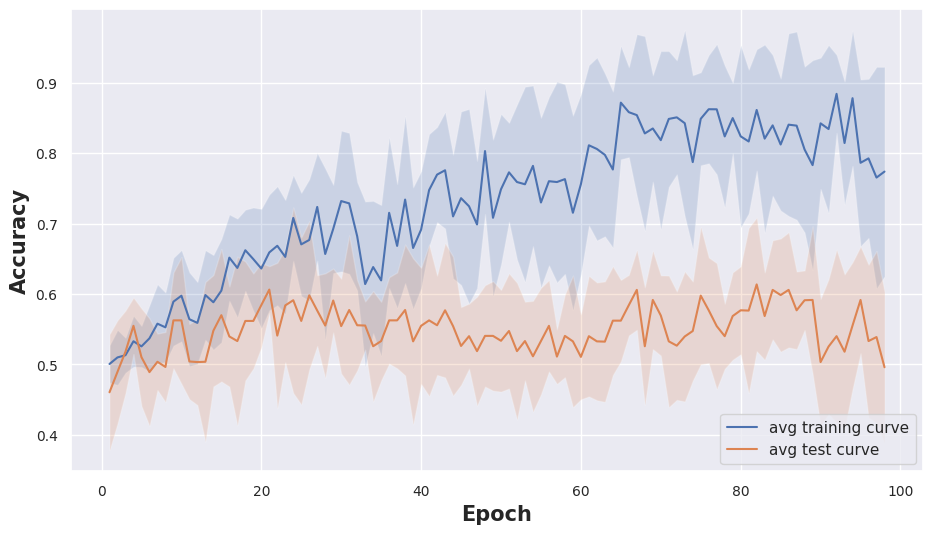

In [13]:
plt.plot(epochs, kfold_mean_train ,label = 'avg training curve')
plt.fill_between(epochs, kfold_mean_train - kfold_std_train, kfold_mean_train + kfold_std_train, alpha=0.2)


plt.plot(epochs, kfold_mean_test ,label = 'avg test curve')
plt.fill_between(epochs, kfold_mean_test - kfold_std_test, kfold_mean_test + kfold_std_test, alpha=0.2)


plt.xlabel('Epoch',fontweight="bold",fontsize=15)
plt.ylabel('Accuracy',fontweight="bold",fontsize=15)

plt.xticks(fontsize=10)
plt.yticks(np.arange(0.4,1,0.1),fontsize=10)

plt.legend(loc = 'lower right')
plt.show()

In [35]:
model = topk(num_node_features, 2)
model.load_state_dict(torch.load('OASIS_topk_gender_cross_val_'+str(1)+'.model'))

<All keys matched successfully>

In [36]:
all_graph = DataLoader(sulcal_dataset, batch_size=len(sulcal_dataset), shuffle=False)

for data in all_graph:
    #prob,g_emb,out_emb,attn_weights = model(data.x, data.edge_index, data.batch)
    out, g_emb, edge_index_1 = model(data.x, data.edge_index, data.batch) # mincut pool

        
g_emb = g_emb.detach().numpy()

In [37]:
from sklearn.manifold import TSNE
import pandas as pd

n_components = 2
tsne = TSNE(n_components)

tsne_graph = tsne.fit_transform(g_emb)
tsne_graph.shape

(137, 2)

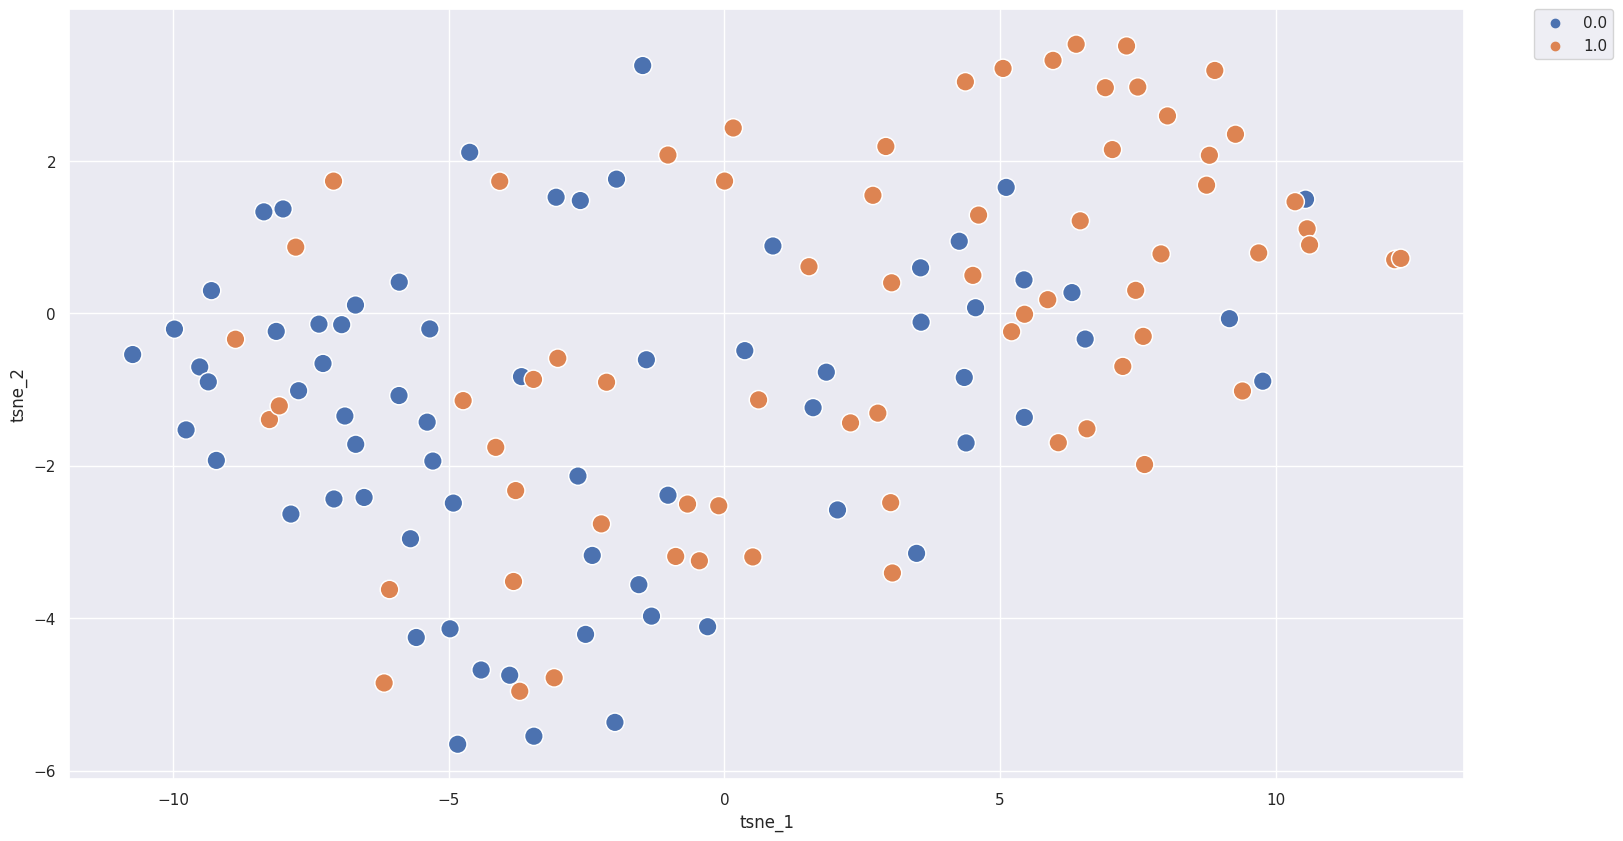

In [38]:
sns.set(rc={'figure.figsize':(18,10)})

#subj_labels_lst = np.arange(0,137,1)
graph_labels_lst = [lab[0] for lab in graph_labels]
tsne_graph_df = pd.DataFrame({'tsne_1': tsne_graph[:,0], 'tsne_2': tsne_graph[:,1], 'label':graph_labels_lst})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_graph_df, ax=ax,s=180)
lim = (tsne_graph_df.min()-5, tsne_graph_df.max()+5)
#ax.set_xlim(lim)
#ax.set_ylim(lim)
#ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# By brain size

In [39]:
from sklearn import preprocessing as pre

all_brain_size = []
all_brain_size_norm = []

for g in list_graphs:
    brain_size = list(nx.get_node_attributes(g,'basin_area'))
    all_brain_size.append(np.sum(brain_size))

x  = np.array(all_brain_size)
x = x.reshape(-1, 1)

all_brain_size_norm = list(pre.MinMaxScaler().fit_transform(x).reshape(len(x)))
    

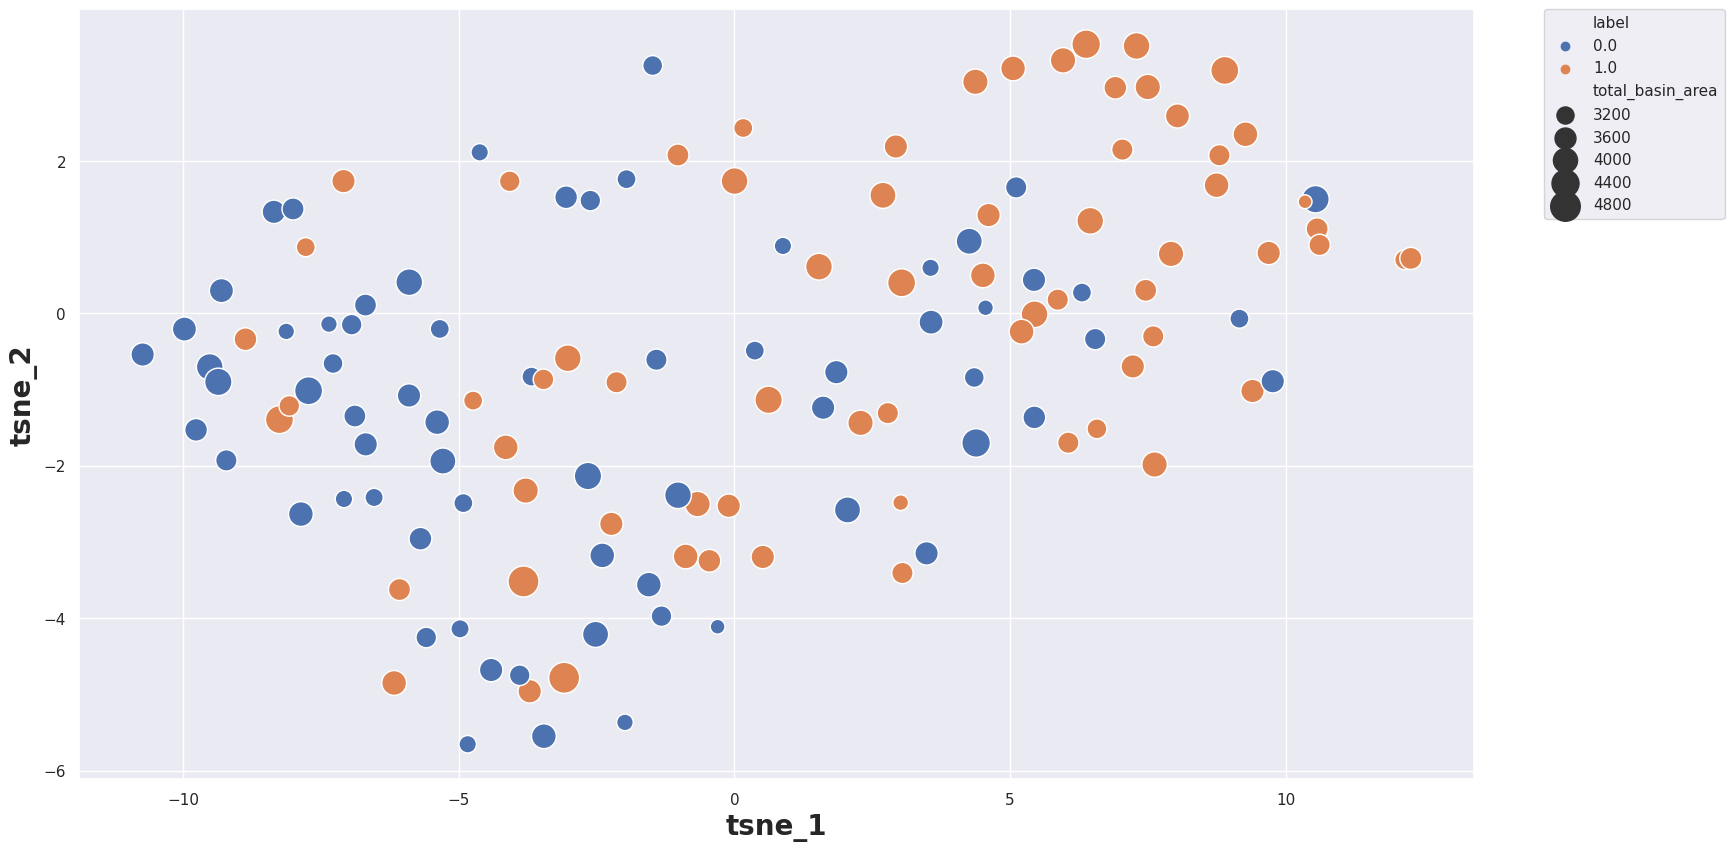

In [40]:
sns.set(rc={'figure.figsize':(18,10)})

tsne_graph_df = pd.DataFrame({'tsne_1': tsne_graph[:,0], 'tsne_2': tsne_graph[:,1], 'label':graph_labels_lst,'total_basin_area':all_brain_size})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label',sizes=(100, 500), data=tsne_graph_df, ax=ax,size='total_basin_area')
#lim = (tsne_graph_df.min()-5, tsne_graph_df.max()+5)

plt.xlabel('tsne_1',fontweight="bold",fontsize=20)
plt.ylabel('tsne_2',fontweight="bold",fontsize=20)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)